# Импорт бибилиотек и функции

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf

from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Dropout

from keras.callbacks import EarlyStopping

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

tf.random.set_seed(43)

In [3]:
EPOCHS = 50
BATCH_SIZE = 32

In [30]:
def plot_training_curves(history):

  tr_mae = history.history['mae'] # mae на тренировочном наборе
  tr_loss = history.history['loss'] # ошибка на тренировочном наборе
  val_mae = history.history['val_mae'] # mae на валидационном наборе
  val_loss = history.history['val_loss']  # ошибка на валидационном наборе
  index_loss = np.argmin(val_loss)
  val_lowest = val_loss[index_loss]
  index_acc = np.argmin(val_mae)
  acc_highest = val_mae[index_acc]
  epochs = [i+1 for i in range(len(tr_mae))] # количество эпох обучения
  loss_label = f'best epoch = {str(index_loss + 1)}'
  acc_label = f'best epoch = {str(index_acc + 1)}'

  # Plot training history
  plt.figure(figsize= (12, 5))
  plt.style.use('fivethirtyeight')

  plt.subplot(1, 2, 1)
  plt.plot(epochs, tr_loss, 'r', label='Ошибка обучения')
  plt.plot(epochs, val_loss, 'g', label='Ошибка валидации')
  plt.scatter(index_loss + 1, val_lowest, s=150, c= 'blue', label=loss_label)
  plt.title('Ошибка при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение ошибки', fontsize=12)
  plt.legend(fontsize=12)

  plt.subplot(1, 2, 2)
  plt.plot(epochs, tr_mae, 'r', label='MAE обучения')
  plt.plot(epochs, val_mae, 'g', label='MAE валидации')
  plt.scatter(index_acc + 1 , acc_highest, s=150, c= 'blue', label=acc_label)
  plt.title('MAE при обучении и валидации', fontsize=14, fontweight="bold")
  plt.xlabel('Эпохи', fontsize=12)
  plt.ylabel('Значение точности', fontsize=12)
  plt.legend(fontsize=12)

  plt.tight_layout
  plt.show()

  return

# Функция для подсчета метрик модели регрессии
def generate_preformance_scores(y_true, y_pred):

  mse = mean_squared_error(y_test, y_pred) # расчет mean squared error
  mae = mean_absolute_error(y_test, y_pred) # расчет mean absolute error
  r2 = r2_score(y_test, y_pred) # расчет коэффициента детерминации r2

  print(f'mse:\t{mse:.4f}')
  print(f'mae:\t{mae:.4f}')
  print(f'r2:\t{r2:.4f}')

  return


def temperature_plot(y_test, y_pred):
  fig, ax = plt.subplots(figsize=(15, 5))

  ax.plot(y_test, c = "g", alpha = 1, label="Тест")
  ax.plot(y_pred, c = "darkblue", alpha = 0.5, label="Предсказание")
  ax.set_title('Сравнение актуальных и предсказанных данных', fontsize=14, fontweight="bold")
  ax.set_xlim(0, len(y_test))
  ax.grid()
  ax.legend()

  return

# Чтение данных

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DL/datasets/yakutsk_weather.csv', sep=";", encoding="windows-1251", encoding_errors='replace', index_col="LocalTime")
df.head()

,T,P0,P,U,DD
LocalTime,,,,,
19.10.2020 17:00,-7.0,745.9,758.2,68.0,Ветер
19.10.2020 16:30,-6.0,746.0,758.2,63.0,Ветер
19.10.2020 16:00,-5.0,746.0,758.2,58.0,Ветер
19.10.2020 15:30,-4.0,746.1,758.2,59.0,Ветер
19.10.2020 15:00,-4.0,746.1,758.2,54.0,Ветер


In [6]:
df.shape

(116051, 5)

# Обработка и исследование данных

In [9]:
df = df.drop(["DD"], axis=1)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116051 entries, 19.10.2020 17:00 to 01.10.2012 00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   T       116050 non-null  float64
 1   P0      116049 non-null  float64
 2   P       116049 non-null  float64
 3   U       116048 non-null  float64
 4   DD      116048 non-null  object 
dtypes: float64(4), object(1)
memory usage: 5.3+ MB


In [10]:
df.describe()

,T,P0,P,U
count,116050.000000,116049.000000,116049.000000,116048.000000
mean,-8.092632,748.080996,760.517001,66.698022
std,21.679891,6.743260,7.464018,17.645702
min,-50.000000,726.800000,738.100000,8.000000
25%,-29.000000,743.400000,755.400000,57.000000
50%,-4.000000,747.700000,759.700000,68.000000
75%,11.000000,752.400000,765.000000,78.000000
max,35.000000,773.400000,787.700000,100.000000


In [11]:
df.isna().sum()

T     1
P0    2
P     2
U     3
dtype: int64

In [12]:
df = df.dropna()
df.isna().sum()

T     0
P0    0
P     0
U     0
dtype: int64

In [13]:
df.shape

(116047, 4)

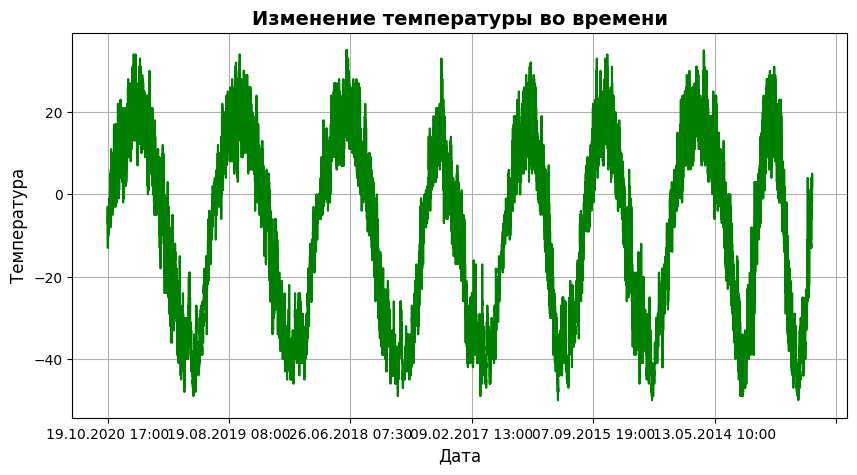

In [17]:
plt.figure(figsize=(10, 5))
df["T"].plot(color='green')
plt.title("Изменение температуры во времени", fontsize=14, fontweight="bold")
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Температура", fontsize=12)
plt.grid()

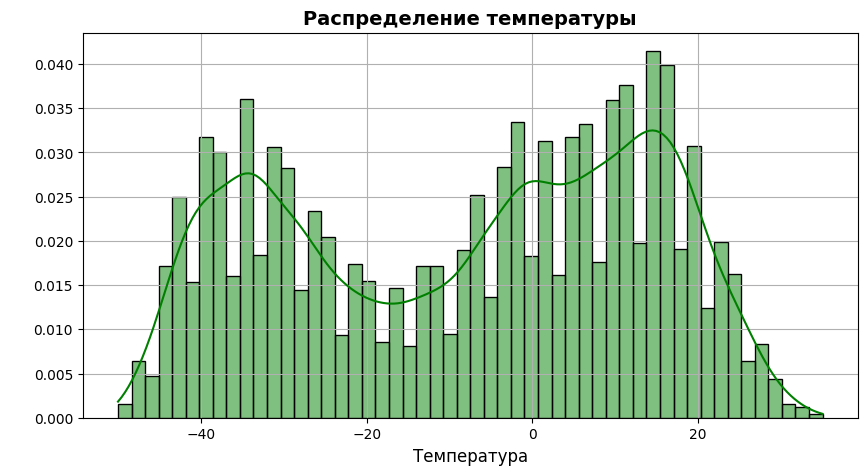

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(df['T'], kde=True, stat="probability", color='green')
plt.title("Распределение температуры", fontsize=14, fontweight="bold")
plt.xlabel("Температура", fontsize=12)
plt.ylabel(" ", fontsize=12)
plt.grid()

# Масштабирование данных

In [18]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [19]:
df_norm = normalize(df.values)
df_norm = pd.DataFrame(df_norm)
df_norm.head()

,0,1,2,3
0,0.050393,-0.323424,-0.310413,0.073785
1,0.096518,-0.308594,-0.310413,-0.209570
2,0.142643,-0.308594,-0.310413,-0.492925
3,0.188769,-0.293764,-0.310413,-0.436254
4,0.188769,-0.293764,-0.310413,-0.719609


# Деление на выборки

In [20]:
def load_data(data, look_back, test_set_ratio):
    data_raw = data.to_numpy()
    data = []

    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(test_set_ratio * data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size, :-1, :]
    y_train = np.squeeze(data[:train_set_size, -1, 0])

    x_test = data[train_set_size:, :-1]
    y_test = np.squeeze(data[train_set_size:, -1, 0])

    return [x_train, y_train, x_test, y_test]

In [21]:
look_back = 20

X_train, y_train, X_test, y_test = load_data(df_norm, look_back, test_set_ratio=0.1)

print('X_train.shape =', X_train.shape)
print('y_train.shape =', y_train.shape)
print('X_test.shape =', X_test.shape)
print('y_test.shape =', y_test.shape)

X_train.shape = (104424, 19, 4)
y_train.shape = (104424,)
X_test.shape = (11603, 19, 4)
y_test.shape = (11603,)


In [22]:
temp_mean = df["T"].mean(axis=0)
temp_std = df["T"].std(axis=0)

In [23]:
y_test = y_test * temp_std + temp_mean

# Модель 1

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

callbacks_list = [early_stop]

## Модель 1.1

In [25]:
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(16, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 19, 8)             40        
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                400       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 457 (1.79 KB)
Trainable params: 457 (1.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
2937/2937 [==============================] - 21s 6ms/step - loss: 0.0302 - mae: 0.0747 - val_loss: 0.0024 - val_mae: 0.0380
Epoch 2/50
2937/2937 [==============================] - 17s 6ms/step - loss: 0.0019 - mae: 0.0321 - val_loss: 0.0018 - val_mae: 0.0319
Epoch 3/50
2937/2937 [==============================] - 17s 6ms/step - loss: 0.0016 - mae: 0.0290 - val_loss: 0.0017 - val_mae: 0.0318
Epoch 4/50
2937/2937 [==============================] - 17s 6ms/step - loss: 0.0015 - mae: 0.0282 - val_loss: 0.0016 - val_mae: 0.0306
Epoch 5/50
2937/2937 [==============================] - 17s 6ms/step - loss: 0.0015 - mae: 0.0278 - val_loss: 0.0016 - val_mae: 0.0303
Epoch 6/50
2937/2937 [==============================] - 17s 6ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 0.0016 - val_mae: 0.0304
Epoch 7/50
2937/2937 [==============================] - 17s 6ms/step - loss: 0.0014 - mae: 0.0272 - val_loss: 0.0017 - val_mae: 0.0306
Epoch 8/50
2937/2937 [==============================] -

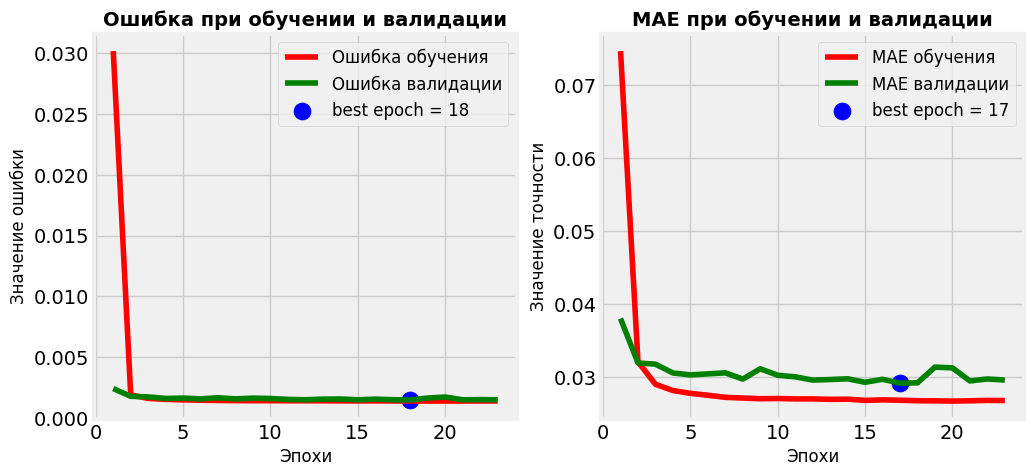

In [28]:
plot_training_curves(history)

363/363 [==============================] - 1s 2ms/step
mse:	1.0639
mae:	0.7600
r2:	0.9979


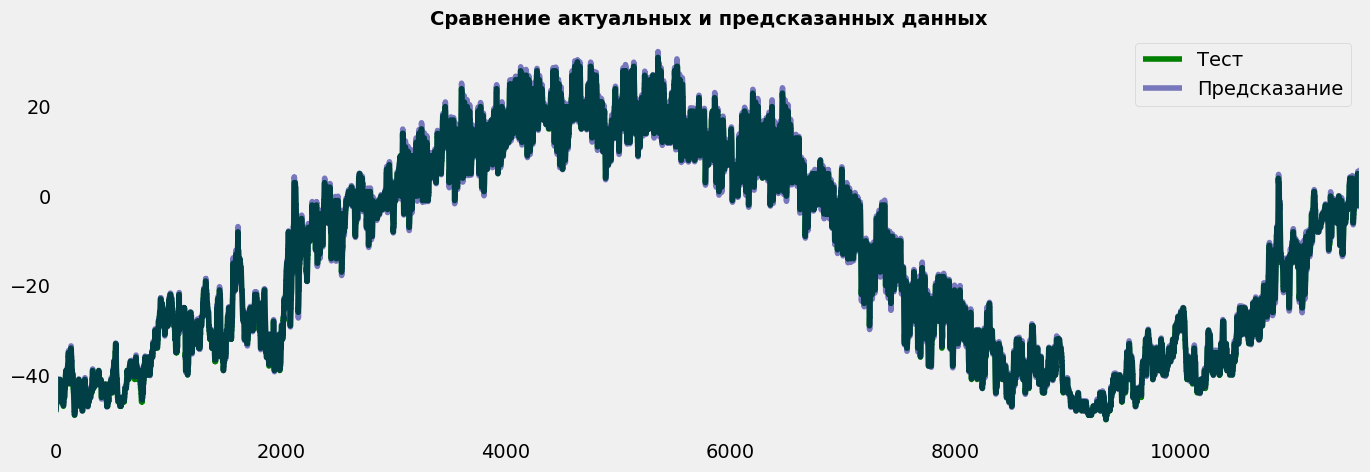

In [31]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 1.2

In [32]:
model = Sequential([
    Dense(4, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(8, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 19, 4)             20        
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 8)                 104       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 133 (532.00 Byte)
Trainable params: 133 (532.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
2937/2937 [==============================] - 21s 7ms/step - loss: 0.0410 - mae: 0.1098 - val_loss: 0.0030 - val_mae: 0.0412
Epoch 2/50
2937/2937 [==============================] - 20s 7ms/step - loss: 0.0022 - mae: 0.0343 - val_loss: 0.0018 - val_mae: 0.0326
Epoch 3/50
2937/2937 [==============================] - 17s 6ms/step - loss: 0.0016 - mae: 0.0291 - val_loss: 0.0016 - val_mae: 0.0307
Epoch 4/50
2937/2937 [==============================] - 17s 6ms/step - loss: 0.0015 - mae: 0.0282 - val_loss: 0.0016 - val_mae: 0.0300
Epoch 5/50
2937/2937 [==============================] - 17s 6ms/step - loss: 0.0015 - mae: 0.0277 - val_loss: 0.0016 - val_mae: 0.0304
Epoch 6/50
2937/2937 [==============================] - 17s 6ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 0.0016 - val_mae: 0.0304
Epoch 7/50
2937/2937 [==============================] - 17s 6ms/step - loss: 0.0015 - mae: 0.0274 - val_loss: 0.0016 - val_mae: 0.0300
Epoch 8/50
2937/2937 [==============================] -

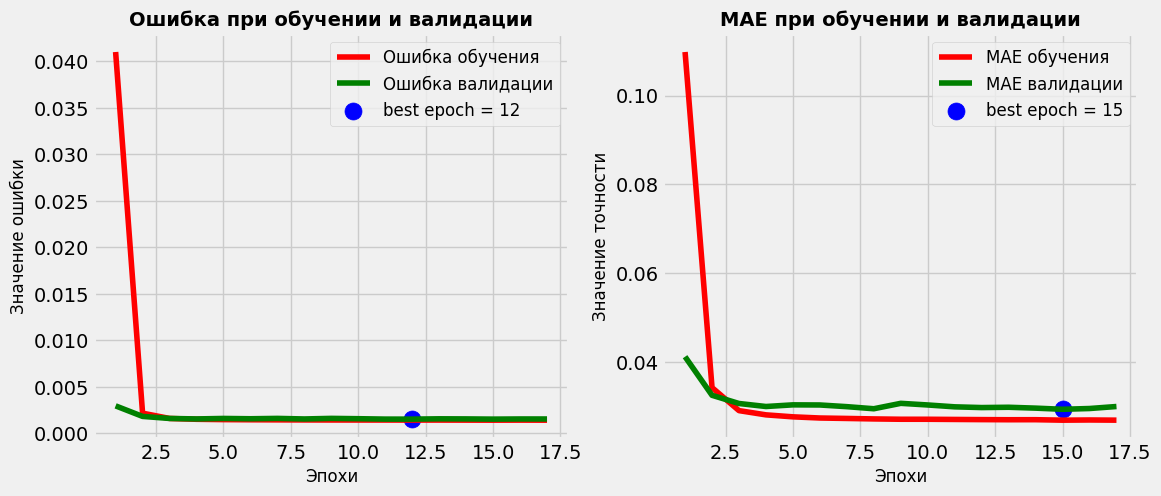

In [34]:
plot_training_curves(history)

363/363 [==============================] - 1s 2ms/step
mse:	1.1208
mae:	0.7854
r2:	0.9978


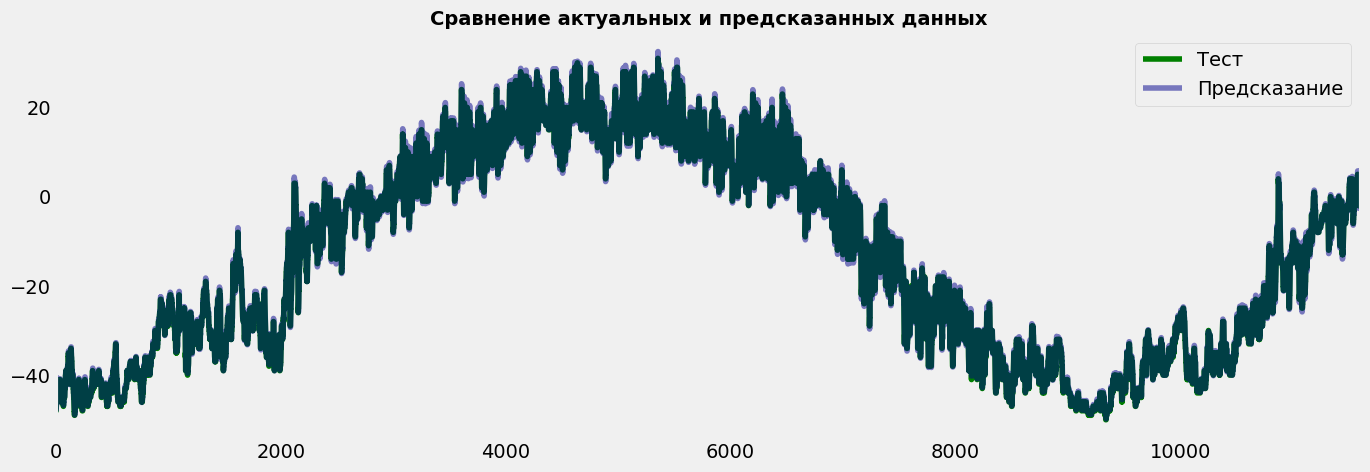

In [35]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 1.3

In [94]:
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(16, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='rmsprop', metrics='mae')
model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 19, 8)             40        
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 16)                400       
                                                                 
 dense_41 (Dense)            (None, 1)                 17        
                                                                 
Total params: 457 (1.79 KB)
Trainable params: 457 (1.79 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [95]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
2937/2937 [==============================] - 37s 11ms/step - loss: 0.0180 - mae: 0.0660 - val_loss: 0.0020 - val_mae: 0.0348
Epoch 2/50
2937/2937 [==============================] - 18s 6ms/step - loss: 0.0019 - mae: 0.0320 - val_loss: 0.0021 - val_mae: 0.0363
Epoch 3/50
2937/2937 [==============================] - 18s 6ms/step - loss: 0.0017 - mae: 0.0299 - val_loss: 0.0019 - val_mae: 0.0338
Epoch 4/50
2937/2937 [==============================] - 18s 6ms/step - loss: 0.0016 - mae: 0.0292 - val_loss: 0.0017 - val_mae: 0.0318
Epoch 5/50
2937/2937 [==============================] - 17s 6ms/step - loss: 0.0016 - mae: 0.0288 - val_loss: 0.0016 - val_mae: 0.0301
Epoch 6/50
2937/2937 [==============================] - 19s 6ms/step - loss: 0.0016 - mae: 0.0285 - val_loss: 0.0016 - val_mae: 0.0306
Epoch 7/50
2937/2937 [==============================] - 18s 6ms/step - loss: 0.0015 - mae: 0.0284 - val_loss: 0.0017 - val_mae: 0.0312
Epoch 8/50
2937/2937 [==============================] 

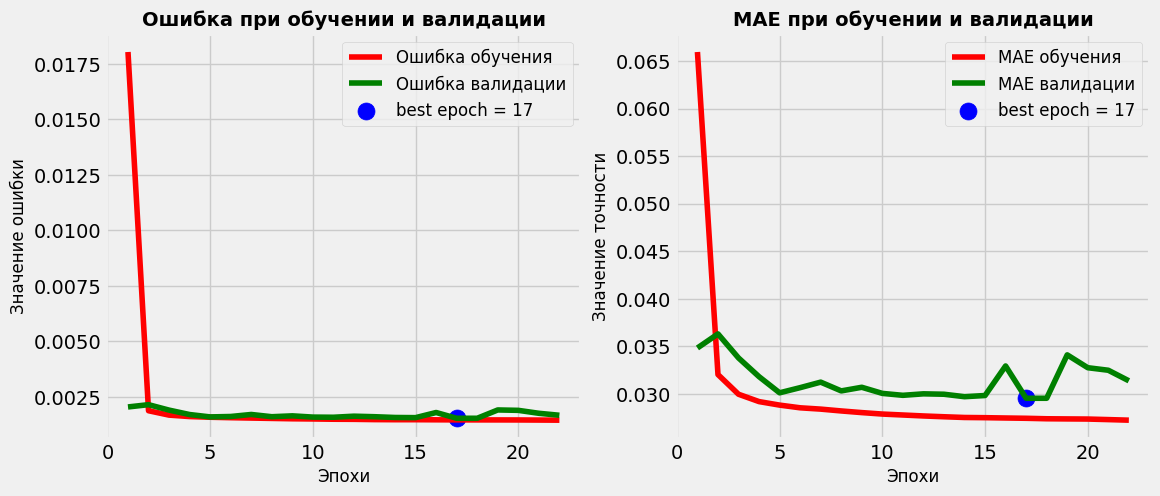

In [96]:
plot_training_curves(history)

363/363 [==============================] - 1s 2ms/step
mse:	1.0605
mae:	0.7485
r2:	0.9979


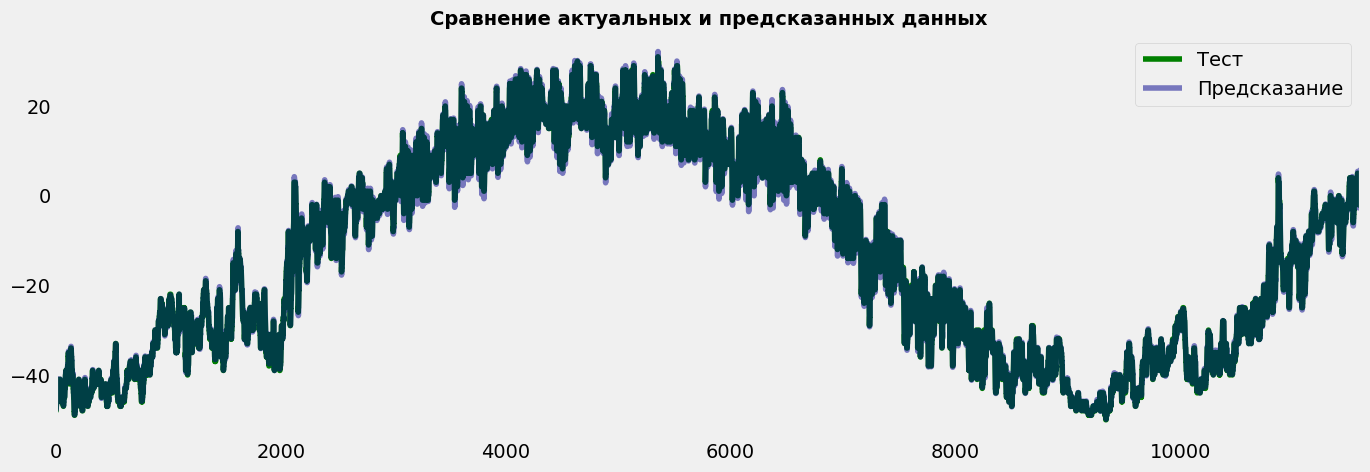

In [73]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

# Модель 2

## Модель 2.1

In [85]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_34 (Dense)            (None, 19, 32)            160       
                                                                 
 lstm_17 (LSTM)              (None, 32)                8320      
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8513 (33.25 KB)
Trainable params: 8513 (33.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [86]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
2937/2937 [==============================] - 35s 11ms/step - loss: 0.0092 - mae: 0.0484 - val_loss: 0.0017 - val_mae: 0.0316
Epoch 2/50
2937/2937 [==============================] - 30s 10ms/step - loss: 0.0017 - mae: 0.0301 - val_loss: 0.0018 - val_mae: 0.0318
Epoch 3/50
2937/2937 [==============================] - 30s 10ms/step - loss: 0.0015 - mae: 0.0287 - val_loss: 0.0016 - val_mae: 0.0304
Epoch 4/50
2937/2937 [==============================] - 29s 10ms/step - loss: 0.0015 - mae: 0.0283 - val_loss: 0.0018 - val_mae: 0.0321
Epoch 5/50
2937/2937 [==============================] - 28s 10ms/step - loss: 0.0015 - mae: 0.0280 - val_loss: 0.0018 - val_mae: 0.0316
Epoch 6/50
2937/2937 [==============================] - 32s 11ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 0.0015 - val_mae: 0.0298
Epoch 7/50
2937/2937 [==============================] - 35s 12ms/step - loss: 0.0014 - mae: 0.0273 - val_loss: 0.0016 - val_mae: 0.0300
Epoch 8/50
2937/2937 [==========================

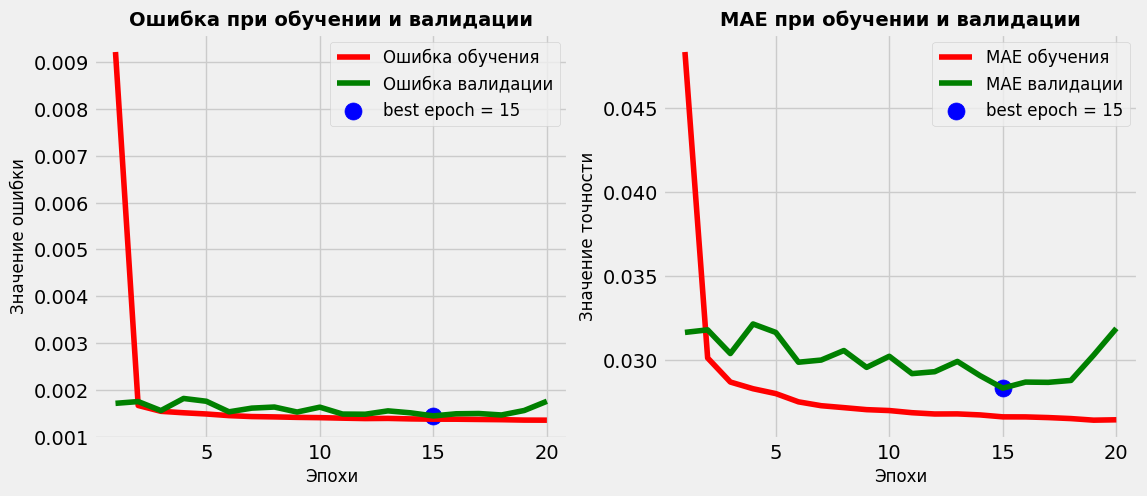

In [87]:
plot_training_curves(history)

363/363 [==============================] - 1s 3ms/step
mse:	1.0883
mae:	0.7849
r2:	0.9979


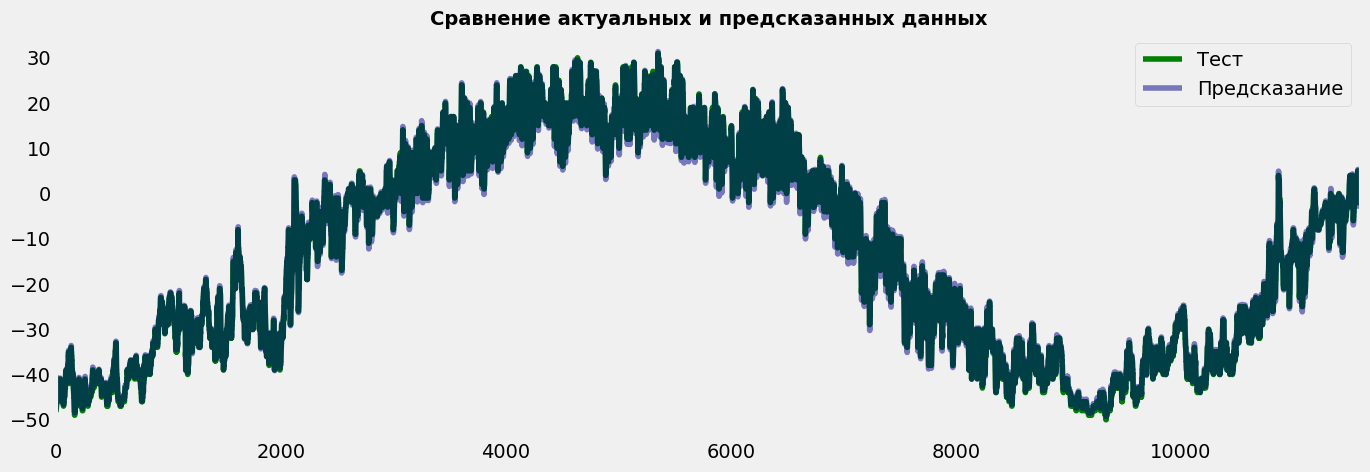

In [88]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 2.2

In [89]:
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(8, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_36 (Dense)            (None, 19, 8)             40        
                                                                 
 lstm_18 (LSTM)              (None, 8)                 544       
                                                                 
 dense_37 (Dense)            (None, 1)                 9         
                                                                 
Total params: 593 (2.32 KB)
Trainable params: 593 (2.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [90]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
2937/2937 [==============================] - 29s 9ms/step - loss: 0.0305 - mae: 0.0811 - val_loss: 0.0029 - val_mae: 0.0412
Epoch 2/50
2937/2937 [==============================] - 24s 8ms/step - loss: 0.0021 - mae: 0.0341 - val_loss: 0.0019 - val_mae: 0.0334
Epoch 3/50
2937/2937 [==============================] - 26s 9ms/step - loss: 0.0016 - mae: 0.0295 - val_loss: 0.0017 - val_mae: 0.0309
Epoch 4/50
2937/2937 [==============================] - 26s 9ms/step - loss: 0.0015 - mae: 0.0281 - val_loss: 0.0016 - val_mae: 0.0298
Epoch 5/50
2937/2937 [==============================] - 25s 9ms/step - loss: 0.0015 - mae: 0.0279 - val_loss: 0.0019 - val_mae: 0.0328
Epoch 6/50
2937/2937 [==============================] - 27s 9ms/step - loss: 0.0015 - mae: 0.0275 - val_loss: 0.0016 - val_mae: 0.0300
Epoch 7/50
2937/2937 [==============================] - 25s 8ms/step - loss: 0.0014 - mae: 0.0273 - val_loss: 0.0016 - val_mae: 0.0297
Epoch 8/50
2937/2937 [==============================] -

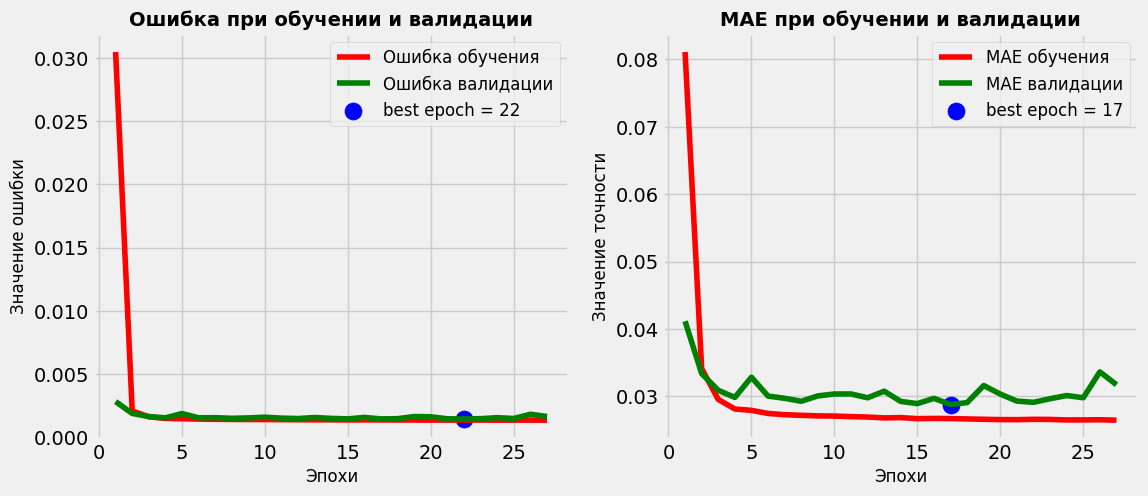

In [91]:
plot_training_curves(history)

363/363 [==============================] - 1s 3ms/step
mse:	1.1395
mae:	0.7955
r2:	0.9978


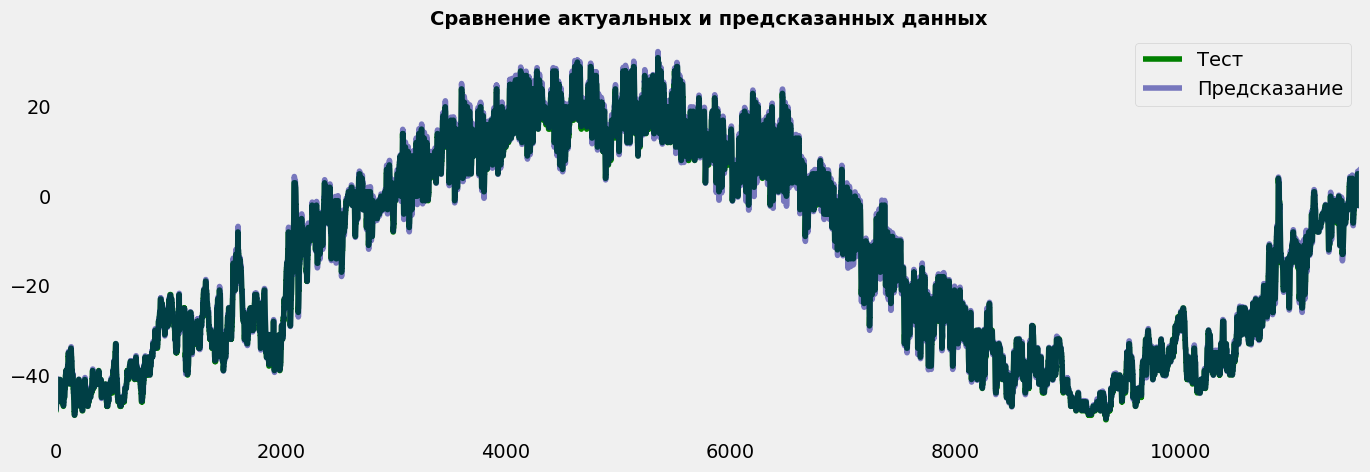

In [92]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 2.3

In [77]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='rmsprop', metrics='mae')
model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 19, 32)            160       
                                                                 
 lstm_15 (LSTM)              (None, 32)                8320      
                                                                 
 dense_31 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8513 (33.25 KB)
Trainable params: 8513 (33.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [78]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
2937/2937 [==============================] - 31s 10ms/step - loss: 0.0068 - mae: 0.0489 - val_loss: 0.0019 - val_mae: 0.0344
Epoch 2/50
2937/2937 [==============================] - 29s 10ms/step - loss: 0.0018 - mae: 0.0318 - val_loss: 0.0020 - val_mae: 0.0349
Epoch 3/50
2937/2937 [==============================] - 30s 10ms/step - loss: 0.0017 - mae: 0.0300 - val_loss: 0.0020 - val_mae: 0.0357
Epoch 4/50
2937/2937 [==============================] - 30s 10ms/step - loss: 0.0016 - mae: 0.0294 - val_loss: 0.0016 - val_mae: 0.0307
Epoch 5/50
2937/2937 [==============================] - 33s 11ms/step - loss: 0.0016 - mae: 0.0290 - val_loss: 0.0015 - val_mae: 0.0295
Epoch 6/50
2937/2937 [==============================] - 30s 10ms/step - loss: 0.0015 - mae: 0.0287 - val_loss: 0.0015 - val_mae: 0.0300
Epoch 7/50
2937/2937 [==============================] - 28s 10ms/step - loss: 0.0015 - mae: 0.0286 - val_loss: 0.0017 - val_mae: 0.0319
Epoch 8/50
2937/2937 [==========================

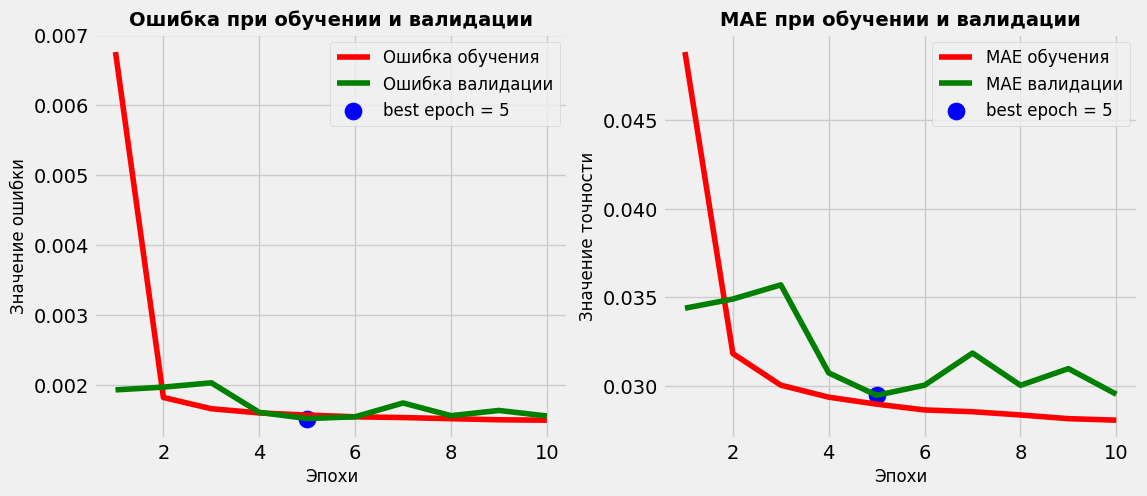

In [79]:
plot_training_curves(history)

363/363 [==============================] - 1s 3ms/step
mse:	1.0374
mae:	0.7523
r2:	0.9980


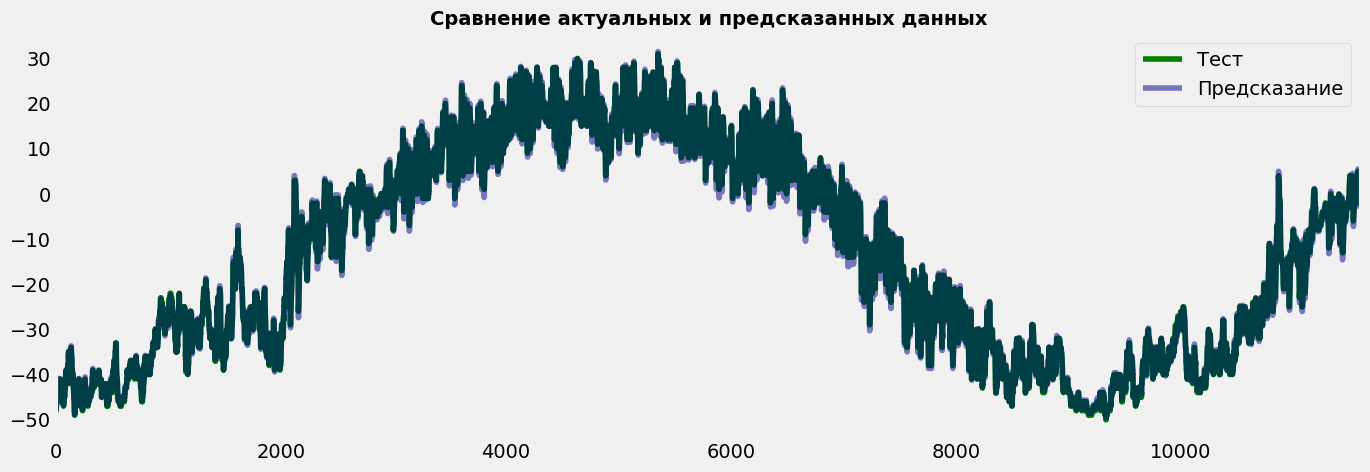

In [80]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 2.4

In [81]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='rmsprop', metrics='mae')
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 19, 32)            160       
                                                                 
 dropout_4 (Dropout)         (None, 19, 32)            0         
                                                                 
 lstm_16 (LSTM)              (None, 32)                8320      
                                                                 
 dropout_5 (Dropout)         (None, 32)                0         
                                                                 
 dense_33 (Dense)            (None, 1)                 33        
                                                                 
Total params: 8513 (33.25 KB)
Trainable params: 8513 (33.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [82]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
2937/2937 [==============================] - 33s 11ms/step - loss: 0.0430 - mae: 0.1525 - val_loss: 0.0063 - val_mae: 0.0586
Epoch 2/50
2937/2937 [==============================] - 31s 11ms/step - loss: 0.0342 - mae: 0.1364 - val_loss: 0.0041 - val_mae: 0.0500
Epoch 3/50
2937/2937 [==============================] - 32s 11ms/step - loss: 0.0331 - mae: 0.1335 - val_loss: 0.0072 - val_mae: 0.0695
Epoch 4/50
2937/2937 [==============================] - 31s 11ms/step - loss: 0.0326 - mae: 0.1319 - val_loss: 0.0055 - val_mae: 0.0583
Epoch 5/50
2937/2937 [==============================] - 31s 11ms/step - loss: 0.0321 - mae: 0.1308 - val_loss: 0.0068 - val_mae: 0.0671
Epoch 6/50
2937/2937 [==============================] - 37s 13ms/step - loss: 0.0319 - mae: 0.1302 - val_loss: 0.0078 - val_mae: 0.0708
Epoch 7/50
2937/2937 [==============================] - 32s 11ms/step - loss: 0.0317 - mae: 0.1294 - val_loss: 0.0071 - val_mae: 0.0700
Epoch 7: early stopping


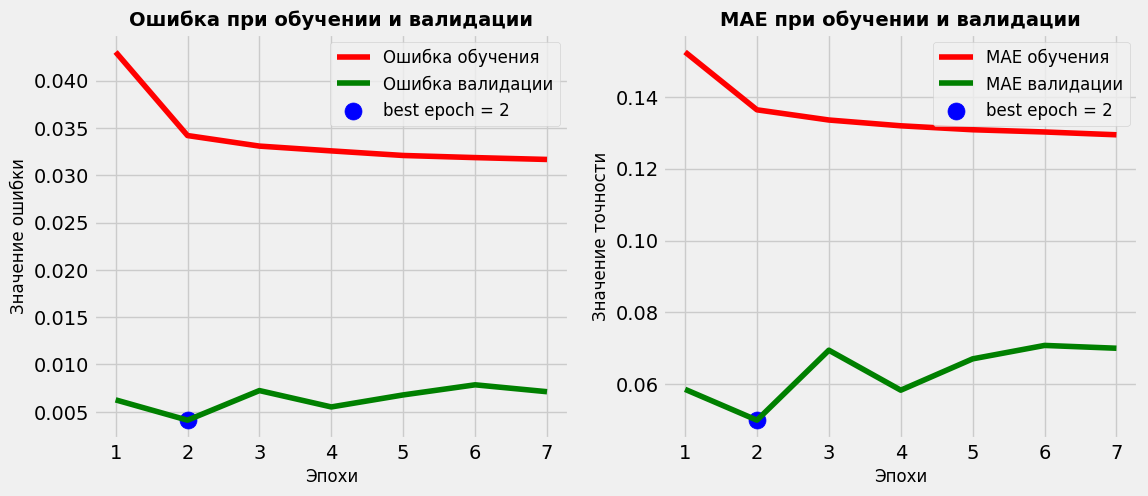

In [83]:
plot_training_curves(history)

363/363 [==============================] - 2s 4ms/step
mse:	3.7691
mae:	1.5819
r2:	0.9926


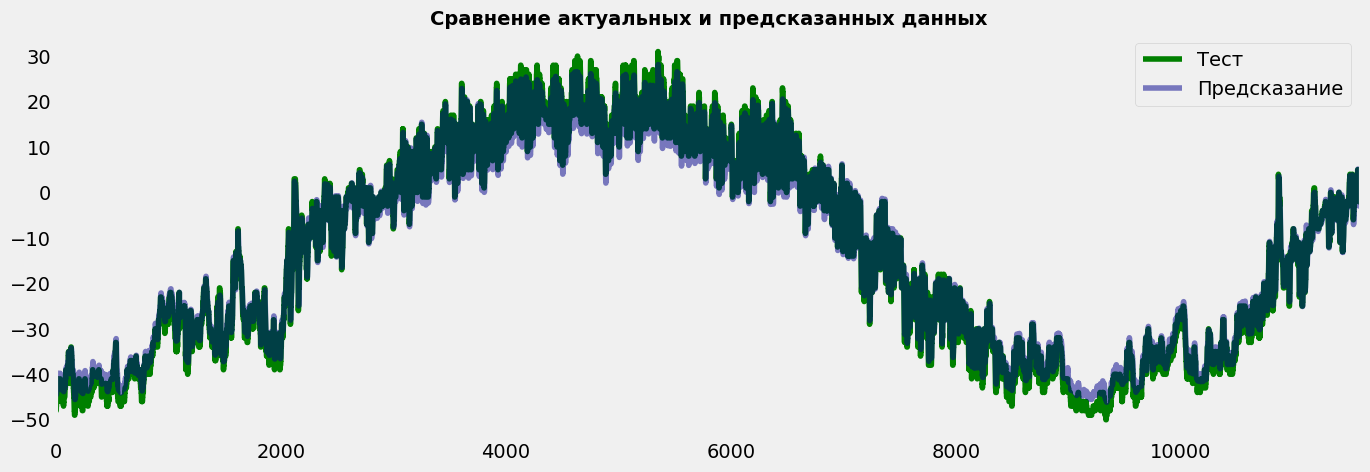

In [84]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

# Модель 3

## Модель 3.1

In [93]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_38 (Dense)            (None, 19, 32)            160       
                                                                 
 lstm_19 (LSTM)              (None, 19, 64)            24832     
                                                                 
 lstm_20 (LSTM)              (None, 32)                12416     
                                                                 
 dense_39 (Dense)            (None, 1)                 33        
                                                                 
Total params: 37441 (146.25 KB)
Trainable params: 37441 (146.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
2937/2937 [==============================] - 64s 21ms/step - loss: 0.0058 - mae: 0.0439 - val_loss: 0.0017 - val_mae: 0.0315
Epoch 2/50
2937/2937 [==============================] - 61s 21ms/step - loss: 0.0017 - mae: 0.0301 - val_loss: 0.0018 - val_mae: 0.0323
Epoch 3/50
2937/2937 [==============================] - 60s 21ms/step - loss: 0.0016 - mae: 0.0292 - val_loss: 0.0016 - val_mae: 0.0296
Epoch 4/50
2937/2937 [==============================] - 60s 21ms/step - loss: 0.0015 - mae: 0.0287 - val_loss: 0.0019 - val_mae: 0.0335
Epoch 5/50
2937/2937 [==============================] - 61s 21ms/step - loss: 0.0015 - mae: 0.0285 - val_loss: 0.0019 - val_mae: 0.0329
Epoch 6/50
2937/2937 [==============================] - 63s 21ms/step - loss: 0.0015 - mae: 0.0278 - val_loss: 0.0016 - val_mae: 0.0298
Epoch 7/50
2937/2937 [==============================] - 61s 21ms/step - loss: 0.0015 - mae: 0.0278 - val_loss: 0.0017 - val_mae: 0.0310
Epoch 8/50
2937/2937 [==========================

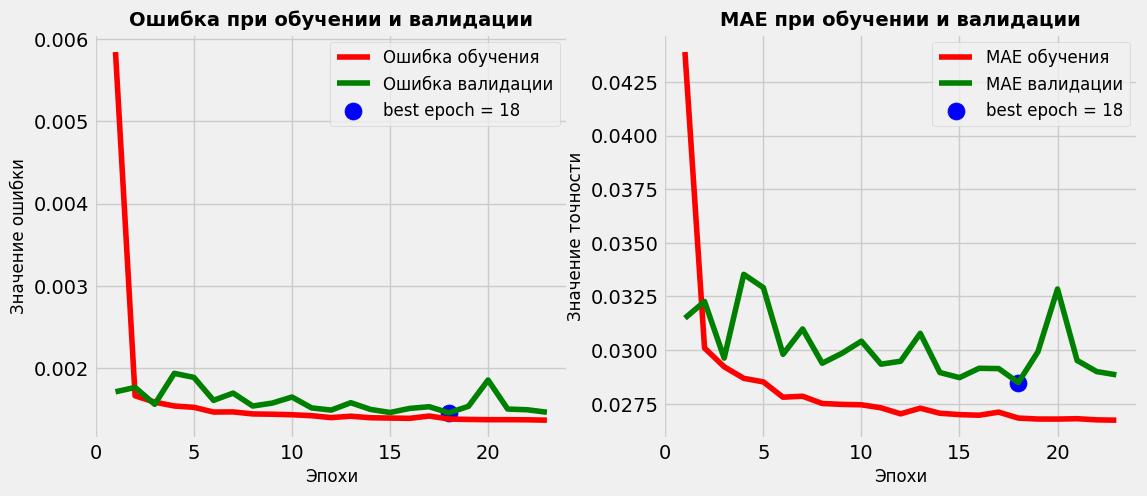

In [57]:
plot_training_curves(history)

363/363 [==============================] - 3s 6ms/step
mse:	1.1076
mae:	0.7869
r2:	0.9978


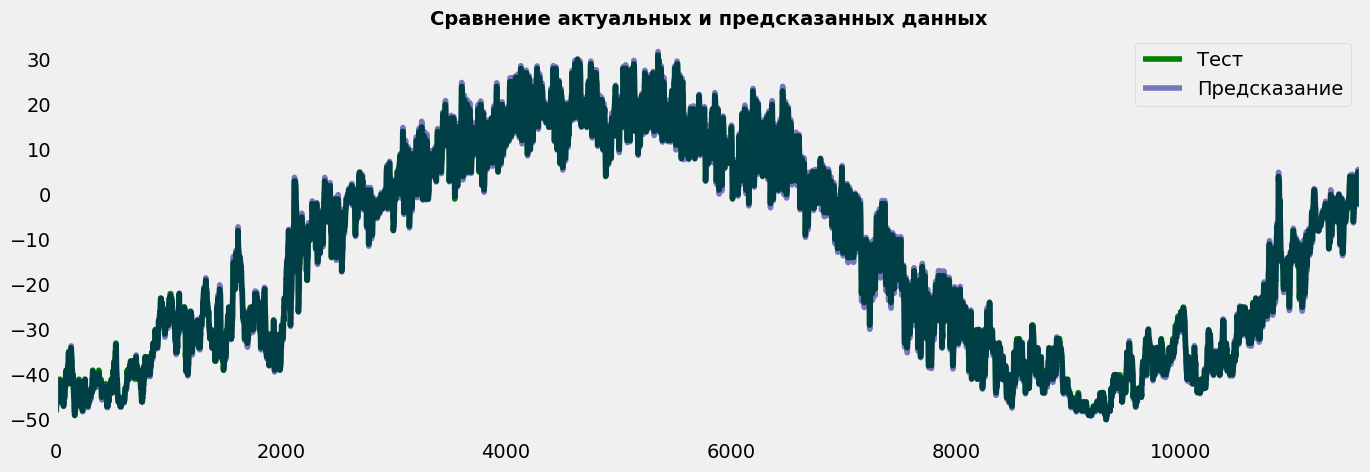

In [58]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 3.2

In [59]:
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32, activation='relu', return_sequences=True),
    LSTM(16, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 19, 16)            80        
                                                                 
 lstm_6 (LSTM)               (None, 19, 32)            6272      
                                                                 
 lstm_7 (LSTM)               (None, 16)                3136      
                                                                 
 dense_17 (Dense)            (None, 1)                 17        
                                                                 
Total params: 9505 (37.13 KB)
Trainable params: 9505 (37.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [60]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
2937/2937 [==============================] - 52s 17ms/step - loss: 0.0134 - mae: 0.0565 - val_loss: 0.0018 - val_mae: 0.0326
Epoch 2/50
2937/2937 [==============================] - 50s 17ms/step - loss: 0.0017 - mae: 0.0307 - val_loss: 0.0018 - val_mae: 0.0320
Epoch 3/50
2937/2937 [==============================] - 49s 17ms/step - loss: 0.0016 - mae: 0.0294 - val_loss: 0.0016 - val_mae: 0.0301
Epoch 4/50
2937/2937 [==============================] - 50s 17ms/step - loss: 0.0016 - mae: 0.0289 - val_loss: 0.0019 - val_mae: 0.0335
Epoch 5/50
2937/2937 [==============================] - 51s 17ms/step - loss: 0.0015 - mae: 0.0287 - val_loss: 0.0021 - val_mae: 0.0350
Epoch 6/50
2937/2937 [==============================] - 50s 17ms/step - loss: 0.0015 - mae: 0.0279 - val_loss: 0.0016 - val_mae: 0.0298
Epoch 7/50
2937/2937 [==============================] - 49s 17ms/step - loss: 0.0015 - mae: 0.0278 - val_loss: 0.0017 - val_mae: 0.0316
Epoch 8/50
2937/2937 [==========================

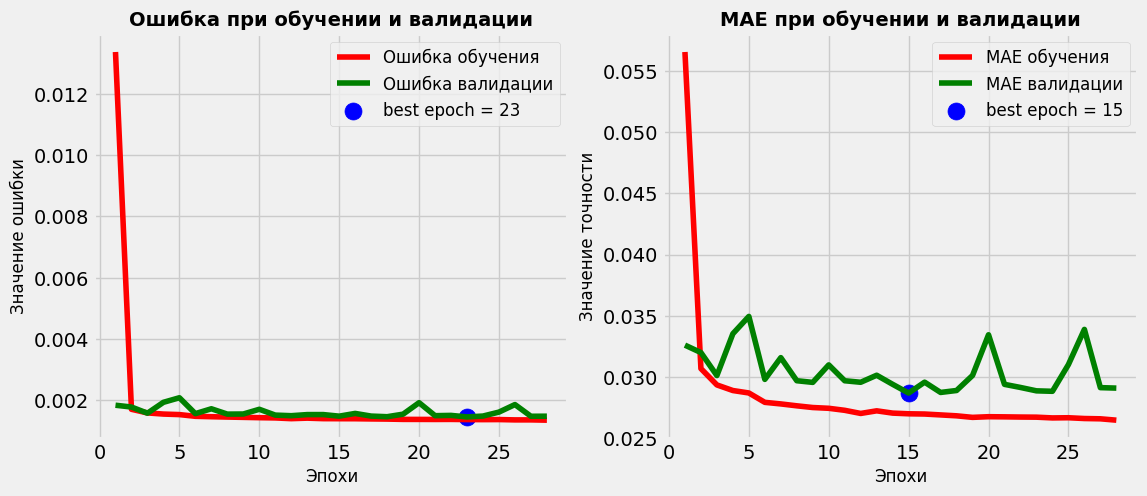

In [61]:
plot_training_curves(history)

363/363 [==============================] - 2s 5ms/step
mse:	1.0545
mae:	0.7542
r2:	0.9979


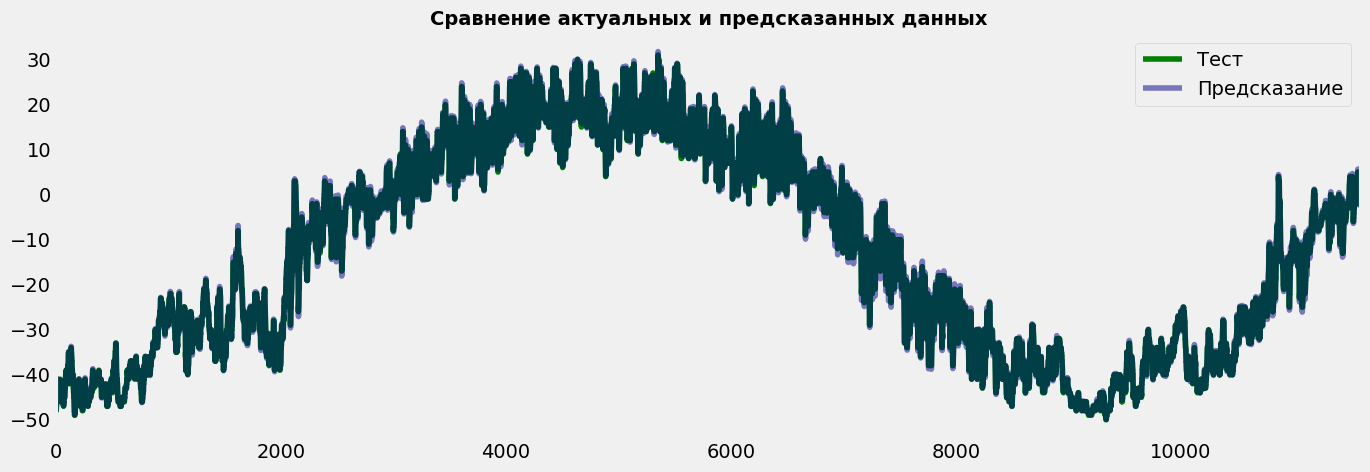

In [62]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 3.3

In [63]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(64, activation='relu', return_sequences=True),
    LSTM(32, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='rmsprop', metrics='mae')
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 19, 32)            160       
                                                                 
 lstm_8 (LSTM)               (None, 19, 64)            24832     
                                                                 
 lstm_9 (LSTM)               (None, 32)                12416     
                                                                 
 dense_19 (Dense)            (None, 1)                 33        
                                                                 
Total params: 37441 (146.25 KB)
Trainable params: 37441 (146.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [64]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
2937/2937 [==============================] - 63s 21ms/step - loss: 0.0096 - mae: 0.0660 - val_loss: 0.0027 - val_mae: 0.0418
Epoch 2/50
2937/2937 [==============================] - 60s 20ms/step - loss: 0.0024 - mae: 0.0371 - val_loss: 0.0028 - val_mae: 0.0429
Epoch 3/50
2937/2937 [==============================] - 61s 21ms/step - loss: 0.0020 - mae: 0.0336 - val_loss: 0.0027 - val_mae: 0.0424
Epoch 4/50
2937/2937 [==============================] - 60s 20ms/step - loss: 0.0019 - mae: 0.0324 - val_loss: 0.0017 - val_mae: 0.0317
Epoch 5/50
2937/2937 [==============================] - 59s 20ms/step - loss: 0.0018 - mae: 0.0316 - val_loss: 0.0016 - val_mae: 0.0299
Epoch 6/50
2937/2937 [==============================] - 59s 20ms/step - loss: 0.0017 - mae: 0.0310 - val_loss: 0.0016 - val_mae: 0.0303
Epoch 7/50
2937/2937 [==============================] - 59s 20ms/step - loss: 0.0017 - mae: 0.0306 - val_loss: 0.0021 - val_mae: 0.0359
Epoch 8/50
2937/2937 [==========================

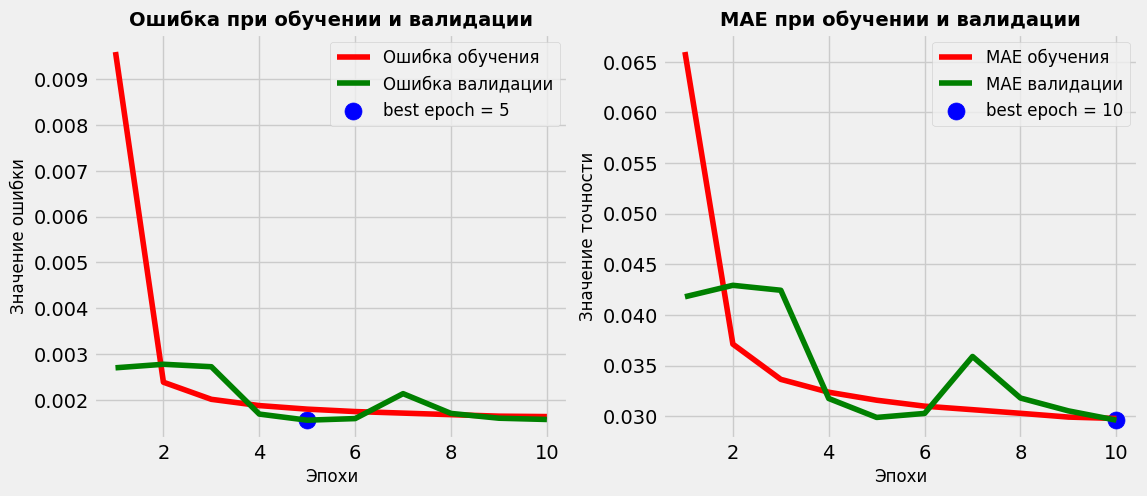

In [65]:
plot_training_curves(history)

363/363 [==============================] - 3s 6ms/step
mse:	1.0358
mae:	0.7512
r2:	0.9980


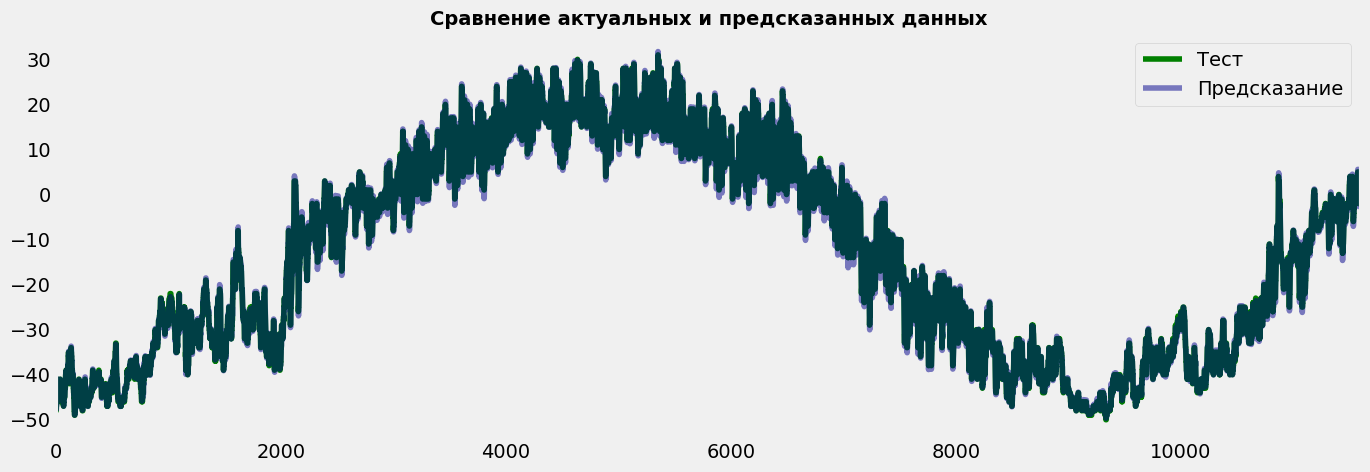

In [66]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)

## Модель 3.4

In [67]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(64, activation='relu', return_sequences=True),
    Dropout(0.1),
    LSTM(32, activation='relu'),
    Dense(1, activation='linear')
    ])

model.compile(loss='mse', optimizer='adam', metrics='mae')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 19, 32)            160       
                                                                 
 dropout_2 (Dropout)         (None, 19, 32)            0         
                                                                 
 lstm_10 (LSTM)              (None, 19, 64)            24832     
                                                                 
 dropout_3 (Dropout)         (None, 19, 64)            0         
                                                                 
 lstm_11 (LSTM)              (None, 32)                12416     
                                                                 
 dense_21 (Dense)            (None, 1)                 33        
                                                                 
Total params: 37441 (146.25 KB)
Trainable params: 374

In [68]:
history = model.fit(X_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    callbacks=callbacks_list
                    )

Epoch 1/50
2937/2937 [==============================] - 70s 23ms/step - loss: 0.0115 - mae: 0.0730 - val_loss: 0.0106 - val_mae: 0.0843
Epoch 2/50
2937/2937 [==============================] - 63s 22ms/step - loss: 0.0039 - mae: 0.0478 - val_loss: 0.0162 - val_mae: 0.1079
Epoch 3/50
2937/2937 [==============================] - 65s 22ms/step - loss: 0.0029 - mae: 0.0408 - val_loss: 0.0154 - val_mae: 0.1065
Epoch 4/50
2937/2937 [==============================] - 64s 22ms/step - loss: 0.0024 - mae: 0.0369 - val_loss: 0.0256 - val_mae: 0.1408
Epoch 5/50
2937/2937 [==============================] - 64s 22ms/step - loss: 0.0022 - mae: 0.0350 - val_loss: 0.0272 - val_mae: 0.1450
Epoch 6/50
2937/2937 [==============================] - 64s 22ms/step - loss: 0.0020 - mae: 0.0334 - val_loss: 0.0266 - val_mae: 0.1433
Epoch 6: early stopping


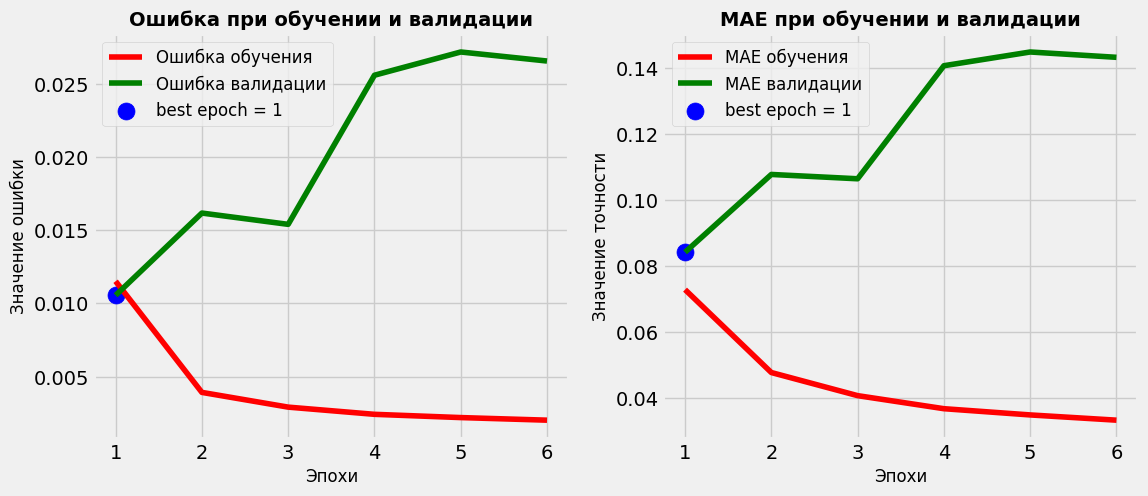

In [69]:
plot_training_curves(history)

363/363 [==============================] - 3s 7ms/step
mse:	13.9866
mae:	3.2468
r2:	0.9726


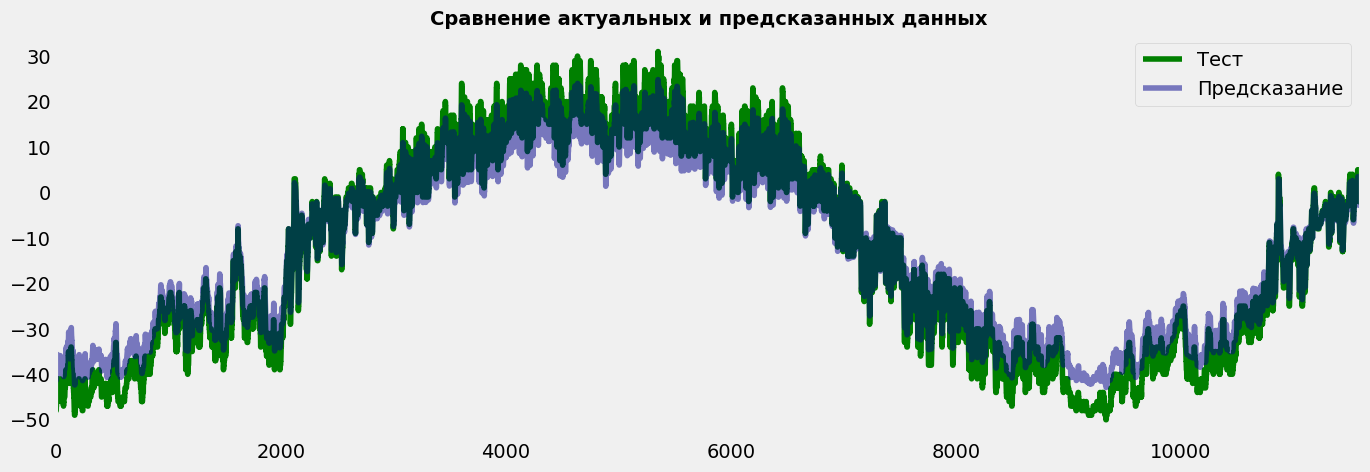

In [70]:
y_pred = model.predict(X_test)
y_pred = y_pred * temp_std + temp_mean

temperature_plot(y_test, y_pred)
generate_preformance_scores(y_test, y_pred)